<a href="https://colab.research.google.com/github/garthajon/QuantFinanceIntro/blob/main/LiquidityAnalysisSpecificZscore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


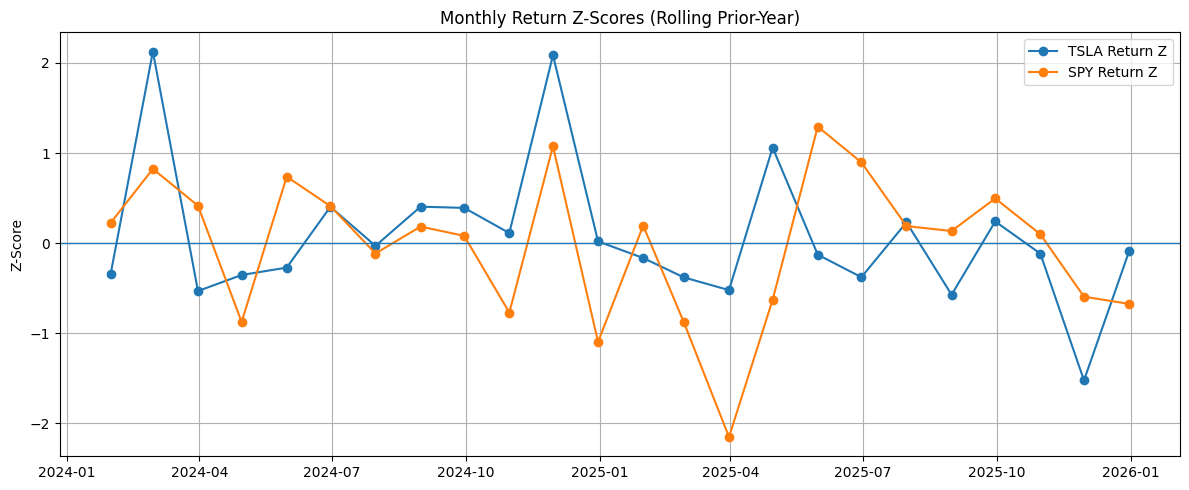

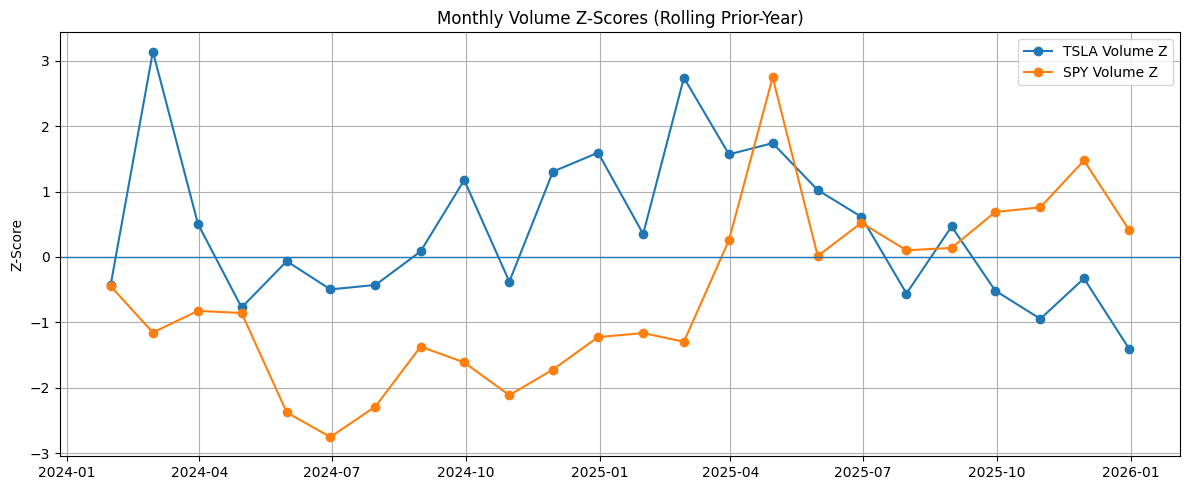

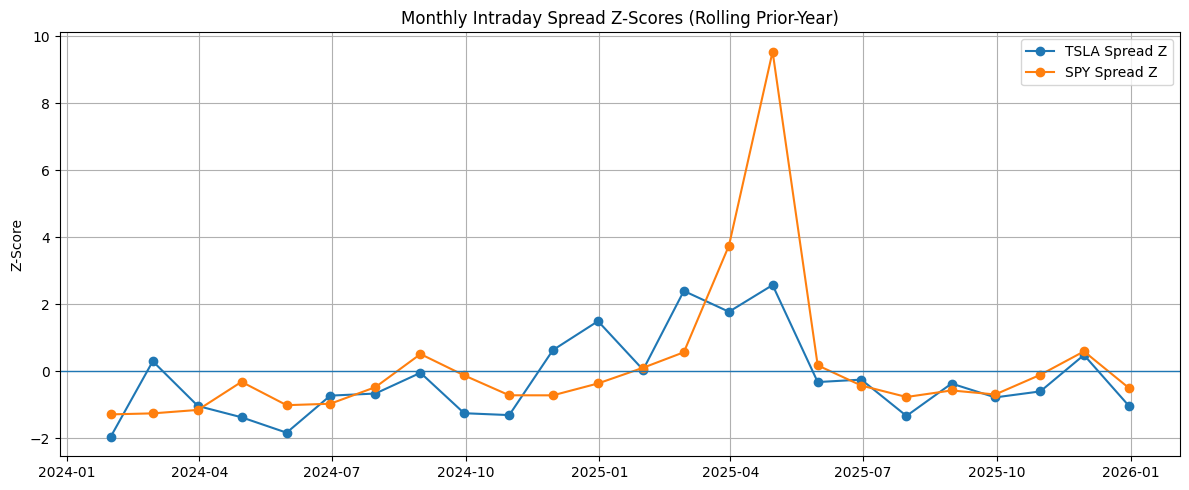

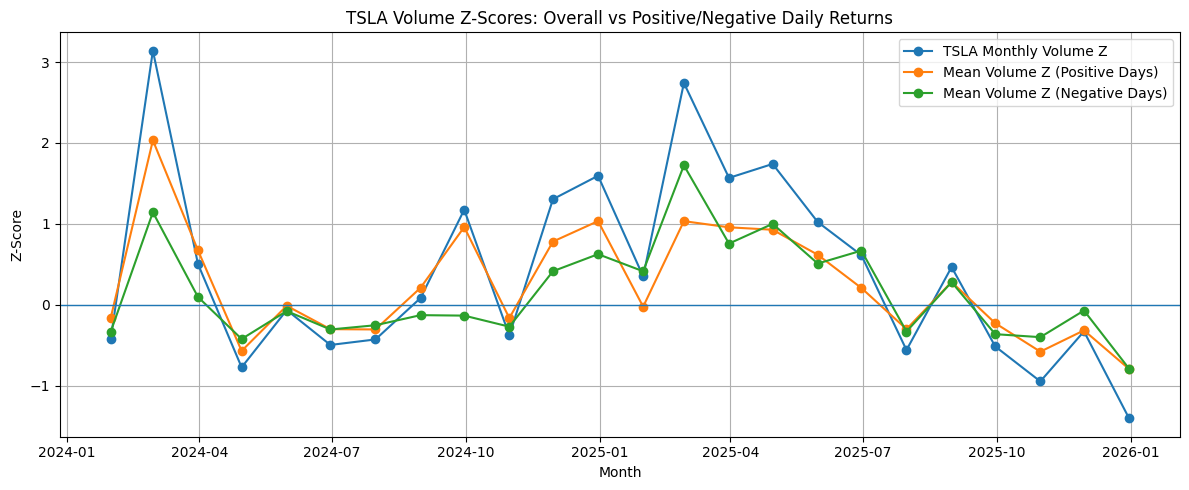

In [36]:

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Parameters
# -----------------------------
lookback_years = 4
rolling_window = 24
months_to_plot = 24
trading_days_per_month = 21  # approximate

# -----------------------------
# Function: monthly z-scores (return, volume, spread)
# -----------------------------
def compute_monthly_zscores(ticker):
    df = yf.download(ticker, period=f"{lookback_years}y", auto_adjust=True)

    if df.empty:
        raise ValueError(f"No data downloaded for {ticker}")

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    # Daily spread return
    prev_close = df["Close"].shift(1)
    df["spread_ret"] = (df["High"] - df["Low"]) / prev_close

    # Monthly aggregation
    monthly = pd.DataFrame({
        "close":  df["Close"].resample("ME").last(),
        "volume": df["Volume"].resample("ME").mean(),
        "spread": df["spread_ret"].resample("ME").mean()
    }).sort_index()

    # Monthly returns
    monthly["returns"] = monthly["close"].pct_change()

    # Rolling prior-year stats
    r_ret = monthly["returns"].shift(1)
    r_vol = monthly["volume"].shift(1)
    r_spr = monthly["spread"].shift(1)

    monthly["ret_mean"] = r_ret.rolling(rolling_window).mean()
    monthly["ret_std"]  = r_ret.rolling(rolling_window).std()
    monthly["vol_mean"] = r_vol.rolling(rolling_window).mean()
    monthly["vol_std"]  = r_vol.rolling(rolling_window).std()
    monthly["spr_mean"] = r_spr.rolling(rolling_window).mean()
    monthly["spr_std"]  = r_spr.rolling(rolling_window).std()

    monthly["ret_z"] = (monthly["returns"] - monthly["ret_mean"]) / monthly["ret_std"]
    monthly["vol_z"] = (monthly["volume"]  - monthly["vol_mean"]) / monthly["vol_std"]
    monthly["spr_z"] = (monthly["spread"]  - monthly["spr_mean"]) / monthly["spr_std"]

    result = monthly.dropna()
    if len(result) < months_to_plot:
        raise ValueError(f"Not enough data to compute {months_to_plot} months for {ticker}")

    return result.tail(months_to_plot), df

# -----------------------------
# Compute TSLA and SPY monthly z-scores
# -----------------------------
tsla_monthly, tsla_daily = compute_monthly_zscores("PLTR")
spy_monthly, spy_daily   = compute_monthly_zscores("SPY")

# -----------------------------
# Daily volume z-score for TSLA (approx daily rolling)
# -----------------------------
tsla_daily["vol_daily_z"] = (tsla_daily["Volume"] - tsla_daily["Volume"].rolling(rolling_window*trading_days_per_month).mean()) / tsla_daily["Volume"].rolling(rolling_window*trading_days_per_month).std()

# Daily return sign
tsla_daily["sign"] = tsla_daily["Close"].diff().apply(lambda x: 1 if x>0 else (-1 if x<0 else 0))

# Monthly mean volume z-score by sign
vol_z_positive = tsla_daily[tsla_daily["sign"]>0].resample("ME")["vol_daily_z"].mean().tail(months_to_plot)
vol_z_negative = tsla_daily[tsla_daily["sign"]<0].resample("ME")["vol_daily_z"].mean().tail(months_to_plot)

# -----------------------------
# Plot: RETURN Z-SCORES
# -----------------------------
plt.figure(figsize=(12, 5))
plt.plot(tsla_monthly.index, tsla_monthly["ret_z"], marker="o", label="TSLA Return Z")
plt.plot(spy_monthly.index,  spy_monthly["ret_z"],  marker="o", label="SPY Return Z")
plt.axhline(0, linewidth=1)
plt.title("Monthly Return Z-Scores (Rolling Prior-Year)")
plt.ylabel("Z-Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# Plot: VOLUME Z-SCORES
# -----------------------------
plt.figure(figsize=(12, 5))
plt.plot(tsla_monthly.index, tsla_monthly["vol_z"], marker="o", label="TSLA Volume Z")
plt.plot(spy_monthly.index,  spy_monthly["vol_z"],  marker="o", label="SPY Volume Z")
plt.axhline(0, linewidth=1)
plt.title("Monthly Volume Z-Scores (Rolling Prior-Year)")
plt.ylabel("Z-Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# Plot: SPREAD Z-SCORES
# -----------------------------
plt.figure(figsize=(12, 5))
plt.plot(tsla_monthly.index, tsla_monthly["spr_z"], marker="o", label="TSLA Spread Z")
plt.plot(spy_monthly.index,  spy_monthly["spr_z"],  marker="o", label="SPY Spread Z")
plt.axhline(0, linewidth=1)
plt.title("Monthly Intraday Spread Z-Scores (Rolling Prior-Year)")
plt.ylabel("Z-Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# Plot: Volume Z by Positive/Negative Daily Returns
# -----------------------------
plt.figure(figsize=(12, 5))
plt.plot(tsla_monthly.index, tsla_monthly["vol_z"], marker="o", label="TSLA Monthly Volume Z")
plt.plot(vol_z_positive.index, vol_z_positive, marker="o", label="Mean Volume Z (Positive Days)")
plt.plot(vol_z_negative.index, vol_z_negative, marker="o", label="Mean Volume Z (Negative Days)")
plt.axhline(0, linewidth=1)
plt.title("TSLA Volume Z-Scores: Overall vs Positive/Negative Daily Returns")
plt.ylabel("Z-Score")
plt.xlabel("Month")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
